# Benchmarking the Recovery of Known Drug Targets from L1000 CRISPR KO Data

In [3]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from IPython.display import display, Markdown
import json
import requests
import time
from random import sample
from math import log2
from maayanlab_bioinformatics.dge import characteristic_direction, limma_voom
from pydeseq2.DeseqDataSet import DeseqDataSet
from pydeseq2.DeseqStats import DeseqStats
from pydeseq2.utils import load_data
# from maayanlab_bioinformatics.normalization import quantile, log, zscore
from maayanlab_bioinformatics.plotting.bridge import bridge_plot
import matplotlib.pyplot as plt

In [44]:
import warnings
warnings.filterwarnings('ignore')

## Load in Data

In [4]:
# Set parameters 
low_expression_threshold = 0.3

In [5]:
# Load in L1000 level 3 data links

l1000_data_dir = '../L1000_data'
l1000_data_file = 'NR1I2_L1000_CRISPRKO_fulldata.tsv'
l1000_meta_file = 'NR1I2_L1000_CRISPRKO_metadata.tsv'
l1000_ctrl_file = 'L1000_Controls_fulldata.tsv'

expr_df = pd.read_csv(f"{l1000_data_dir}/{l1000_data_file}", sep='\t', index_col=0)
expr_df.head()

,XPR010_A375.311_96H_X1_B35:F08,XPR010_A375.311_96H_X2_B35:F08,XPR010_A375.311_96H_X3_B35:F08,XPR010_A375.311_96H_X1_B35:F24,XPR010_A375.311_96H_X2_B35:F24,XPR010_A375.311_96H_X3_B35:F24,XPR010_A549.311_96H_X1.L2_B36:F08,XPR010_A549.311_96H_X3_B35:F08,XPR010_A549.311_96H_X1.L2_B36:F24,XPR010_A549.311_96H_X3_B35:F24,...,XPR010_U251MG.311_96H_X3_B35:F08,XPR010_U251MG.311_96H_X1_B35:F24,XPR010_U251MG.311_96H_X2_B35:F24,XPR010_U251MG.311_96H_X3_B35:F24,XPR010_YAPC.311_96H_X1_B35:F08,XPR010_YAPC.311_96H_X2_B35:F08,XPR010_YAPC.311_96H_X3_B35:F08,XPR010_YAPC.311_96H_X1_B35:F24,XPR010_YAPC.311_96H_X2_B35:F24,XPR010_YAPC.311_96H_X3_B35:F24
symbol,,,,,,,,,,,,,,,,,,,,,
DDR1,6.158450,6.202200,6.285650,6.249500,6.071100,6.225575,6.03340,6.26310,6.29285,6.52600,...,6.41030,6.8449,6.698900,6.50580,6.553050,7.549575,6.84630,6.780425,6.951875,6.821550
PAX8,6.011775,6.106200,5.664900,5.665750,5.471950,5.780600,4.99225,5.30080,4.62410,4.82470,...,5.23020,4.5078,5.127000,5.00560,5.445525,5.153600,4.25930,5.035250,4.937550,4.004100
GUCA1A,4.835400,4.938175,4.842400,4.697725,4.872650,4.826450,5.21620,5.17145,4.99370,5.02665,...,4.89295,4.7672,4.806500,4.92165,5.290500,5.622600,5.89155,5.574350,5.208800,5.685100
EPHB3,6.632500,6.971400,6.574300,6.753650,6.427550,6.769800,8.29650,7.51050,7.67320,8.04430,...,8.03480,8.9509,7.990300,7.93880,7.675250,7.396850,6.47865,7.833150,7.967200,7.705101
ESRRA,7.819700,7.858900,8.497725,8.272900,8.056351,7.891300,8.73630,8.28170,8.84240,8.22250,...,7.25300,6.8591,7.123001,7.13630,8.613050,8.440750,7.94130,8.899151,8.561750,8.045325


In [6]:
meta_df = pd.read_csv(f"{l1000_data_dir}/{l1000_meta_file}", sep='\t', index_col=0)
meta_df['batch'] = meta_df.index.map(lambda x: '_'.join(x.split('_')[:3]))
meta_df.head()

,tissue,disease,cell_line,pert_name,pert_time,pert_type,data_level,creation_time,persistent_id,pert_dose,batch
id,,,,,,,,,,,
XPR010_A375.311_96H_X1_B35:F08,skin of body,melanoma,A375.311,NR1I2,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR010_A375.311_96H
XPR010_A375.311_96H_X2_B35:F08,skin of body,melanoma,A375.311,NR1I2,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR010_A375.311_96H
XPR010_A375.311_96H_X3_B35:F08,skin of body,melanoma,A375.311,NR1I2,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR010_A375.311_96H
XPR010_A375.311_96H_X1_B35:F24,skin of body,melanoma,A375.311,NR1I2,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR010_A375.311_96H
XPR010_A375.311_96H_X2_B35:F24,skin of body,melanoma,A375.311,NR1I2,96 h,CRISPR Knockout,3,2021-01-21,https://lincs-dcic.s3.amazonaws.com/LINCS-data...,NaN,XPR010_A375.311_96H


In [14]:
batches = meta_df['batch'].unique()
len(batches)

10

## Load in Control Data

In [9]:
ctrl_expr_df = pd.read_csv(f"{l1000_data_dir}/{l1000_ctrl_file}", sep='\t', index_col=0)
ctrl_expr_df.head()

,XPR010_A375.311_96H_X1_B35:A06,XPR010_A375.311_96H_X2_B35:A06,XPR010_A375.311_96H_X3_B35:A06,XPR010_A375.311_96H_X1_B35:D05,XPR010_A375.311_96H_X2_B35:D05,XPR010_A375.311_96H_X3_B35:D05,XPR010_A375.311_96H_X1_B35:D20,XPR010_A375.311_96H_X2_B35:D20,XPR010_A375.311_96H_X3_B35:D20,XPR010_A375.311_96H_X1_B35:D21,...,XPR010_YAPC.311_96H_X3_B35:E14,XPR010_YAPC.311_96H_X1_B35:F04,XPR010_YAPC.311_96H_X2_B35:F04,XPR010_YAPC.311_96H_X3_B35:F04,XPR010_YAPC.311_96H_X1_B35:H24,XPR010_YAPC.311_96H_X2_B35:H24,XPR010_YAPC.311_96H_X3_B35:H24,XPR010_YAPC.311_96H_X1_B35:K17,XPR010_YAPC.311_96H_X2_B35:K17,XPR010_YAPC.311_96H_X3_B35:K17
symbol,,,,,,,,,,,,,,,,,,,,,
NAT2,7.260575,7.280875,7.02010,6.966801,7.45305,7.79865,7.34975,7.165100,7.708175,7.48150,...,12.6010,8.773951,8.02120,12.157150,7.691299,7.311550,12.085751,8.362350,9.20055,11.97370
ADA,5.064700,5.259250,5.22435,5.144300,5.38295,5.03075,5.07075,5.199075,4.932025,5.28315,...,4.6644,4.806450,4.66950,3.391350,5.972750,5.615875,4.137550,6.133075,4.75340,4.23540
CDH2,5.706775,5.822050,5.69430,5.853000,5.64155,5.71160,5.98715,5.800150,5.671200,5.80255,...,6.0781,5.741250,5.86595,5.915725,5.294300,6.179800,6.161100,5.736300,5.83550,5.75765
AKT3,0.896850,2.521300,2.37685,1.295950,3.11635,2.51195,2.38330,1.790250,1.295950,3.40630,...,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
MED6,5.884050,5.757250,5.77825,5.589350,6.05750,5.44470,5.63980,5.929700,5.832875,5.86350,...,6.2660,5.605700,6.17515,5.849500,5.851400,6.168350,5.662300,5.871375,6.37535,6.18240


In [10]:
ctrl_meta_df = pd.read_csv(f"{l1000_data_dir}/L1000_NR1I2_Controls_metadata.tsv", sep='\t', index_col=0)
ctrl_meta_df.head()

,batch
id,
XPR010_A375.311_96H_X1_B35:A06,XPR010_A375.311_96H
XPR010_A375.311_96H_X2_B35:A06,XPR010_A375.311_96H
XPR010_A375.311_96H_X3_B35:A06,XPR010_A375.311_96H
XPR010_A375.311_96H_X1_B35:D05,XPR010_A375.311_96H
XPR010_A375.311_96H_X2_B35:D05,XPR010_A375.311_96H


## Normalize Data

### Remove duplicate genes

In [11]:
combined_df = pd.concat([
    expr_df.groupby(expr_df.index).mean(), 
    ctrl_expr_df.groupby(ctrl_expr_df.index).mean()
], axis=1)
combined_df.head()

,XPR010_A375.311_96H_X1_B35:F08,XPR010_A375.311_96H_X2_B35:F08,XPR010_A375.311_96H_X3_B35:F08,XPR010_A375.311_96H_X1_B35:F24,XPR010_A375.311_96H_X2_B35:F24,XPR010_A375.311_96H_X3_B35:F24,XPR010_A549.311_96H_X1.L2_B36:F08,XPR010_A549.311_96H_X3_B35:F08,XPR010_A549.311_96H_X1.L2_B36:F24,XPR010_A549.311_96H_X3_B35:F24,...,XPR010_YAPC.311_96H_X3_B35:E14,XPR010_YAPC.311_96H_X1_B35:F04,XPR010_YAPC.311_96H_X2_B35:F04,XPR010_YAPC.311_96H_X3_B35:F04,XPR010_YAPC.311_96H_X1_B35:H24,XPR010_YAPC.311_96H_X2_B35:H24,XPR010_YAPC.311_96H_X3_B35:H24,XPR010_YAPC.311_96H_X1_B35:K17,XPR010_YAPC.311_96H_X2_B35:K17,XPR010_YAPC.311_96H_X3_B35:K17
symbol,,,,,,,,,,,,,,,,,,,,,
A1CF,4.45315,4.23635,4.634250,3.93165,3.87275,3.75120,5.3409,4.67510,5.60880,5.23860,...,10.192900,10.741025,10.62880,10.17440,11.360250,10.609800,10.58320,11.2271,11.164000,10.640949
A2M,7.22560,7.47065,8.596849,7.24335,7.29490,7.76080,8.1608,5.55060,8.57160,5.88430,...,8.146475,7.649900,8.25165,8.60140,7.470325,7.525375,7.99345,7.0502,8.668000,8.725750
A4GALT,5.43295,5.44650,5.665200,5.29545,5.68145,5.51620,6.7321,6.05495,6.72805,5.74780,...,5.415850,6.452750,5.52640,5.43765,5.709750,6.054850,4.93555,6.1569,6.114300,4.902300
A4GNT,5.37260,5.28950,5.293250,5.18680,5.30390,5.38095,5.2655,5.52010,5.44740,5.62385,...,8.344800,8.872550,8.37400,8.79715,8.576900,8.662701,8.30970,8.8629,8.714951,8.285049
AAAS,7.51980,7.64780,7.956600,7.59620,8.07660,7.87480,8.1372,7.55920,8.28530,7.90890,...,6.719550,6.666550,6.71455,6.97565,6.509600,6.576250,6.78680,6.4280,6.527250,6.776250


In [12]:
datasets = {
    'metadata': meta_df, 
    'ctrl_metadata': ctrl_meta_df,
    'rawdata': combined_df
}

## Compute Signatures: All Perturbations vs. All Controls

In [15]:
all_ctrls = ctrl_meta_df[ctrl_meta_df['batch'].isin(batches)].index.tolist()
all_cases = meta_df.index.tolist()
print(f"{len(all_ctrls)} controls; {len(all_cases)} cases")

255 controls; 57 cases


In [16]:
signatures = {}

### Characteristic Direction

In [17]:
# Function for computing signatures with characteristic direction
def cd_signature(ctrl_ids, case_ids, dataset, normalization):
  
    signature = characteristic_direction(
        dataset[normalization].loc[:, ctrl_ids], 
        dataset[normalization].loc[:, case_ids], 
        calculate_sig=True
    )
    signature = signature.sort_values("CD-coefficient", ascending=False)
    
    return signature

signatures['cd'] = cd_signature(all_ctrls, all_cases, datasets, 'rawdata')

### Limma

In [43]:
# Function for computing signatures
def limma(ctrl_ids, case_ids, dataset, normalization):
    
    signature = limma_voom.limma_voom_differential_expression(
        dataset[normalization].loc[:, ctrl_ids],
        dataset[normalization].loc[:, case_ids],
        filter_genes=False
    )
    signature = signature.sort_values("t", ascending=False)

    return signature

signatures['limma'] = limma(all_ctrls, all_cases, datasets, 'rawdata')

/Users/maayanlab/opt/anaconda3/envs/scatterenv/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:55: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


### Fold Change

In [19]:
# Function for computing signatures with fold change
def logFC(ctrl_ids, case_ids, dataset, normalization):

    case_mean = dataset[normalization].loc[:, case_ids].mean(axis=1)
    ctrl_mean = dataset[normalization].loc[:, ctrl_ids].mean(axis=1)
    
    signature = case_mean / ctrl_mean
    
    return signature.apply(lambda x: log2(x+0.001)).sort_values(ascending=False)

signatures['logfc'] = logFC(all_ctrls, all_cases, datasets, 'rawdata')

In [45]:
# Display signatures
for sig in signatures.keys():
    display(Markdown(f"{sig.upper()} signature"))
    display(signatures[sig])

CD signature

,CD-coefficient,Significance
symbol,,
RPL39,0.031370,-0.007355
CKAP4,0.030087,-0.034598
NOP56,0.029782,-0.020786
OSBPL10,0.029454,-0.018358
MIF,0.028891,-0.025698
...,...,...
GRM6,-0.029214,-0.035711
CRIP1,-0.031476,-0.036066
CCL18,-0.031654,-0.030960


LIMMA signature

,logFC,AveExpr,t,P.Value,adj.P.Val,B
RPL21,1.339036,6.173466,250.703198,0.0,0.0,822.884021
RPS29,1.311133,6.229129,245.943435,0.0,0.0,816.923221
RPL28,1.060911,6.309981,217.045259,0.0,0.0,778.123715
RPS16,1.337775,6.118881,215.807575,0.0,0.0,776.360591
S100A13,1.293220,6.144913,211.078920,0.0,0.0,769.484176
...,...,...,...,...,...,...
AMHR2,-1.520721,7.029374,-224.579192,0.0,0.0,788.571709
CTNNA3,-1.299244,7.082721,-252.440442,0.0,0.0,824.778679
GSTA3,-1.521701,7.078893,-257.481186,0.0,0.0,830.899844
CNGB3,-1.236888,7.045509,-264.892177,0.0,0.0,839.693453


LOGFC signature

symbol
VPS50      4.166870
MYOZ1      3.426401
AKT3       3.330225
RAX        3.284045
F2RL1      3.194978
             ...   
SFTPB     -3.316894
COL11A1   -3.410921
NPR3      -3.496523
OLFML2B   -4.433259
WIF1      -4.504957
Length: 12327, dtype: float64

## Enrichment Analysis Rankings

In [51]:
# Function to get Enrichr Results
def Enrichr_API(enrichr_gene_list, library_name, method, direction):

    all_ranks = []
    all_terms = []
    all_pvalues =[] 
    all_adjusted_pvalues = []

    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
    genes_str = '\n'.join(enrichr_gene_list)
    description = f'Dex benchmark {method} {direction} genes'
    payload = {
        'list': (None, genes_str),
        'description': (None, description)
    }

    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error uploading gene list')

    list_data = json.loads(response.text)
    time.sleep(0.5)
    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
    response = requests.get(
        ENRICHR_URL + f"?userListId={list_data['userListId']}&backgroundType={library_name}"
    )
    if not response.ok:
        raise Exception('Error fetching enrichment results')

    enrich_data = json.loads(response.text)
    results_df  = pd.DataFrame(enrich_data[library_name])
    all_ranks.append(list(results_df[0]))
    all_terms.append(list(results_df[1]))
    all_pvalues.append(list(results_df[2]))
    all_adjusted_pvalues.append(list(results_df[6]))

    res_dict = {
        'ranks': all_ranks, 
        'terms': all_terms, 
        'pvals': all_pvalues,
        'adjpvals': all_adjusted_pvalues, 
        'shortid': str(list_data['shortId'])
    }

    return res_dict

In [52]:
# Get gene lists to put into Enrichr
gene_lists = {'up': {}, 'down': {}, 'combined': {}}
for sig in signatures.keys():
    gene_lists['up'][sig] = signatures[sig].head(250).index.tolist()
    gene_lists['down'][sig] = signatures[sig].tail(250).index.tolist()
    gene_lists['combined'][sig] = gene_lists['up'][sig] + gene_lists['down'][sig]

In [53]:
# Get results
results = {'up': {}, 'down': {}, 'combined': {}}
for direction in results.keys():
    for sig in signatures.keys():
        results[direction][sig] = Enrichr_API(
            gene_lists[direction][sig], 'ChEA_2022', sig, direction
        )

In [54]:
# Extract dexamethasone target rankings
# Initialize lists for storing target information
ranks = []
targets = ['NR1I2']

for sig in signatures.keys(): 
    for direction in results.keys():
        for i in range(len(results[direction][sig]['ranks'][0])): 
            if any(t in results[direction][sig]['terms'][0][i] for t in targets): 
                ranks.append([
                    f"{sig}:{direction}",
                    results[direction][sig]['terms'][0][i], 
                    results[direction][sig]['ranks'][0][i],
                    results[direction][sig]['pvals'][0][i]
                ])
full_df = pd.DataFrame(ranks, columns=['Gene_Set', 'Term', 'Rank', 'p-value'])
full_df['Method'] = full_df['Gene_Set'].apply(lambda x: x.split(':')[0])
full_df['Direction'] = full_df['Gene_Set'].apply(lambda x : x.split(':')[1])

In [55]:
up_df = full_df[full_df['Direction']=='up']
down_df = full_df[full_df['Direction']=='down']
combined_df = full_df[full_df['Direction']=='combined']

In [56]:
display(Markdown("Mean ranks of Dex target gene terms from ChEA 2022 for up genes from each method."))
display(up_df.groupby(['Method']).mean(numeric_only=True).sort_values(['Rank', 'Method']).drop(['p-value'], axis=1))
display(Markdown("Mean ranks of Dex target gene terms from ChEA 2022 for down genes from each method."))
display(down_df.groupby(['Method']).mean(numeric_only=True).sort_values(['Rank', 'Method']).drop(['p-value'], axis=1))
display(Markdown("Mean ranks of Dex target gene terms from ChEA 2022 for combined up and down genes from each method."))
display(combined_df.groupby(['Method']).mean(numeric_only=True).sort_values(['Rank', 'Method']).drop(['p-value'], axis=1))

Mean ranks of Dex target gene terms from ChEA 2022 for up genes from each method.

,Rank
Method,
limma,329.0
logfc,485.0
cd,624.0


Mean ranks of Dex target gene terms from ChEA 2022 for down genes from each method.

,Rank
Method,
cd,11.0
limma,78.0
logfc,154.0


Mean ranks of Dex target gene terms from ChEA 2022 for combined up and down genes from each method.

,Rank
Method,
limma,163.0
cd,208.0
logfc,287.0


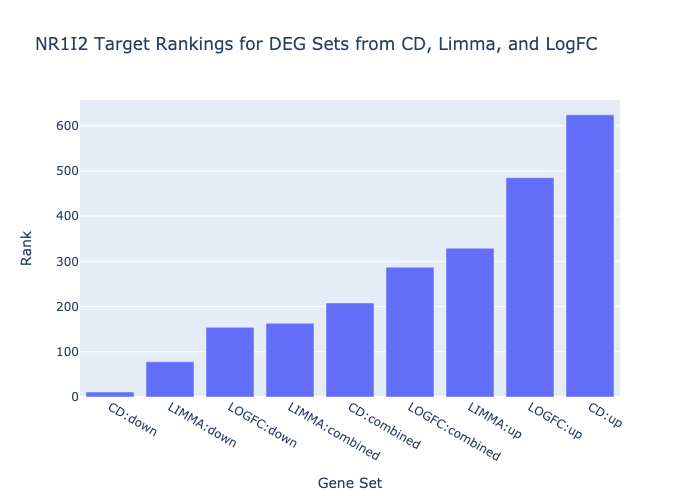

In [57]:
fig1 = go.Figure()
fig1.add_trace(
    go.Bar(
        x=full_df['Gene_Set'].apply(lambda x: x.split(':')[0].upper() + ':' + x.split(':')[1]),
        y=full_df['Rank']
    )
)

fig1.update_layout(
    title_text=f"NR1I2 Target Rankings for DEG Sets from CD, Limma, and LogFC",
    xaxis={
        'title': {'text': 'Gene Set'}, 
        "categoryorder":"total ascending"
    },
    yaxis={
        'title': {'text': 'Rank'}
    },
    showlegend=False
)
fig1.show("png")

### Bridge plots

In [58]:
def getEnrichrGeneSets(libname, termlist): 
    term_dict = {}
    liburl = f'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=json&libraryName={libname}'
    response = requests.get(liburl)
    if not response.ok:
        raise Exception('Error fetching library from Enrichr')
    for term in termlist:
        geneset = response.json()[libname]['terms'][term].keys()
        term_dict[term] = geneset
    return term_dict

target_genesets = getEnrichrGeneSets('ChEA_2022', full_df['Term'].unique())

In [68]:
signatures['all']= pd.concat([
    signatures['cd']['CD-coefficient'].rename('CD'),
    signatures['limma']['t'].rename('Limma'),
    signatures['logfc'].rename('FC')
], axis=1).sort_index()

display(Markdown(f"All method batch signatures"))
display(signatures['all'])

All method batch signatures

,CD,Limma,FC
A1CF,-0.017820,-84.308335,-1.261590
A2M,0.003565,3.715530,0.096797
A4GALT,0.001515,-0.909829,-0.018055
A4GNT,-0.013798,-51.832837,-0.823225
AAAS,0.005724,37.345428,0.312267
...,...,...,...
ZXDB,-0.000573,-5.443047,-0.056247
ZXDC,-0.005480,-19.726465,-0.399950
ZYX,0.016204,37.246425,0.959661
ZZEF1,-0.007347,-8.678706,-0.274555


In [90]:
def singleBridgePlot(gsname, colname, abs_val=False):
    geneset = target_genesets[gsname]

    if abs_val:
        abs_vals = signatures['all'][colname].apply(abs).sort_values(ascending=False)
        select = pd.Series(
            [x.upper() in geneset for x in abs_vals.index.tolist()]
        )
    else:
        select = pd.Series(
            [x.upper() in geneset for x in signatures['all'][colname].sort_values(ascending=False).index.tolist()]
        )
    x, y = bridge_plot(select)
    x = x/len(x)
    return x,y

def randomBridgePlot(gsname): 
    all_x = []
    all_y = []

    for _ in range(10):
        rand_sig = sample(
            signatures['cd']['CD-coefficient'].index.tolist(), 
            signatures['cd']['CD-coefficient'].shape[0]
        )
        select = pd.Series([
            x.upper() in target_genesets[gsname] for x in rand_sig
        ])
        x, y = bridge_plot(select)
        x = x/len(x)
        all_x.append(x)
        all_y.append(y)

    return all_x, all_y

In [91]:
def build_res(abs_val=False):
    res = {}
    for term in target_genesets.keys():
        res[term] = {'random': {'x': [], 'y': []}}
        rand_x, rand_y = randomBridgePlot(term)
        res[term]['random']['x'] += rand_x
        res[term]['random']['y'] += rand_y
        for col in signatures['all'].columns:
            temp_x, temp_y = singleBridgePlot(term, col, abs_val=abs_val)
            if col in res[term].keys():
                res[term][col]['x'].append(temp_x)
                res[term][col]['y'].append(temp_y)
            else: 
                res[term][col] = {'x': [temp_x], 'y': [temp_y]}
    return res

method_results = build_res(abs_val=False)
method_results_abs = build_res(abs_val=True)

In [98]:
def tfBridgePlot(abs_val=False):
    if abs_val:
        res = method_results_abs
    else: 
        res = method_results
    for term in res.keys():
        for sig in res[term].keys(): 
            term_x = np.mean(res[term][sig]['x'], axis=0)
            term_y = np.mean(res[term][sig]['y'], axis=0)
            if sig == 'random': 
                plt.plot(term_x, term_y, label=sig, color='gray')
            elif sig == 'CD': 
                plt.plot(term_x-(0.01*max(term_x)), term_y, label=sig)
            else:
                plt.plot(term_x, term_y, label=sig)

        plt.axhline(y=0, color='black', linestyle='dashed')
        plt.legend(bbox_to_anchor=(1, 1))
        if abs_val:
            plt.title(f"{term.split(' ')[0]} Target Gene Rankings for Each Method (Abs Val)")
        else:
            plt.title(f"{term.split(' ')[0]} Target Gene Rankings for Each Method")
        plt.show()

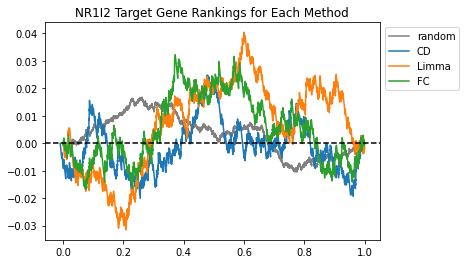

In [99]:
tfBridgePlot()

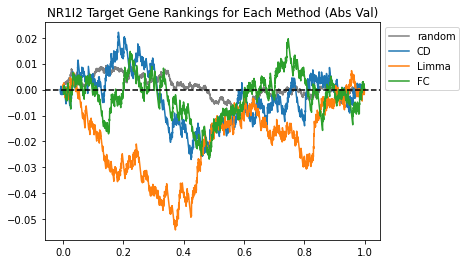

In [100]:
tfBridgePlot(abs_val=True)